<a href="https://colab.research.google.com/github/leeebs/B-A-Writer/blob/main/1_ARIMA%EB%AA%A8%ED%98%95%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
%matplotlib inline

import itertools

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/시계열/AirPassengers.csv')

In [ ]:
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [ ]:
data = data.rename(columns={'Month':'month', '#Passengers':'Passengers'})
data['month'] = pd.to_datetime(data['month']) # month라는 칼럼을 datetime(시간)
data = data.set_index('month') # month 칼럼을 인덱스로 설정
data.asfreq('MS')

,Passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


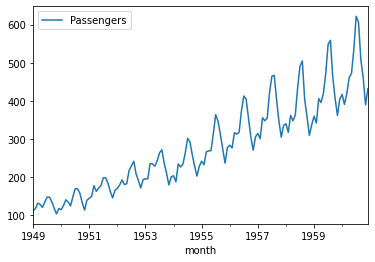

In [ ]:
data.plot()

### 정상성 체크 - 시계열 분해

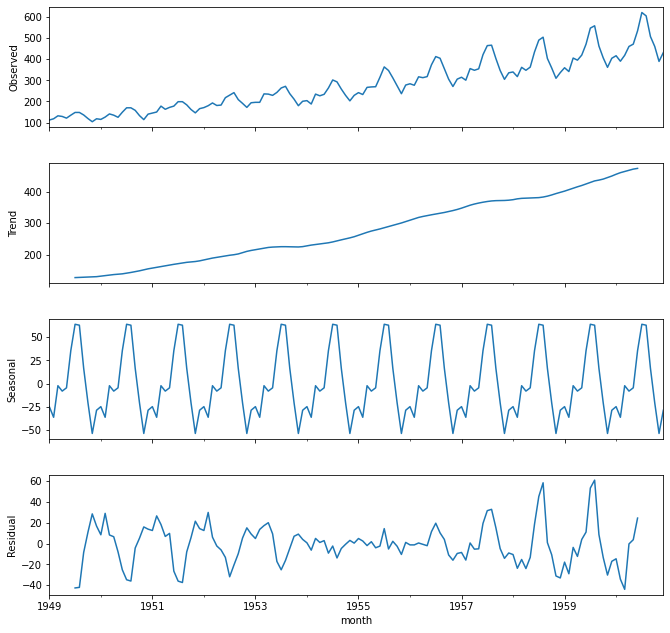

In [ ]:
# decomposition tsa = time series analysis -> s 추세와 계절 더하기
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='additive') # 시계열 분해, decomposition
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

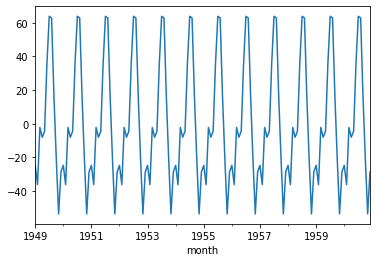

In [ ]:
decomposition.seasonal.dropna().plot()

In [ ]:
decomposition.seasonal.dropna()

month
1949-01-01   -24.748737
1949-02-01   -36.188131
1949-03-01    -2.241162
1949-04-01    -8.036616
1949-05-01    -4.506313
                ...    
1960-08-01    62.823232
1960-09-01    16.520202
1960-10-01   -20.642677
1960-11-01   -53.593434
1960-12-01   -28.619949
Name: Passengers, Length: 144, dtype: float64

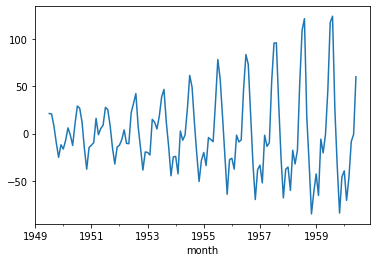

In [ ]:
# detrend = 원래 데이터 - 추세 데이터
(data['Passengers'] - decomposition.trend).plot()

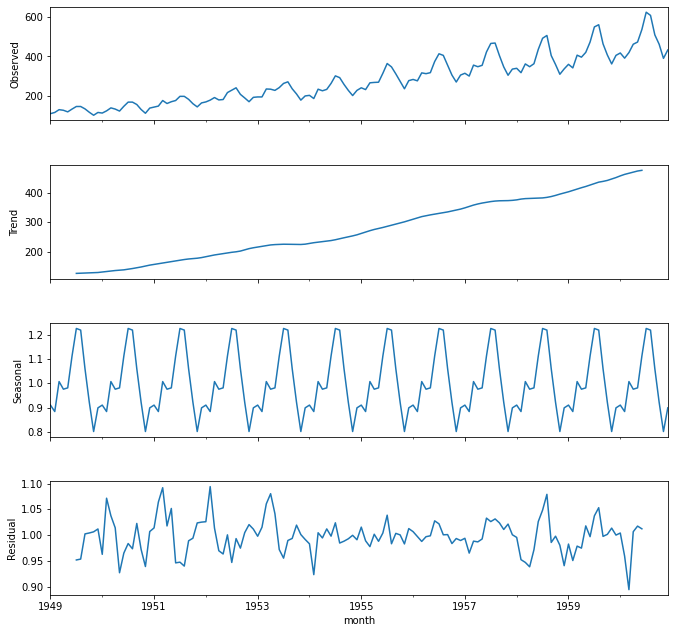

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='multiplicative') # 시계열 분해(곱하기로) 후 decomposition 변수에 결과 저장
fig = decomposition.plot() 
fig.set_size_inches(10,10)
plt.show()

### 정상화 과정

#### 시계열 데이터에 어떤 연산을 할 수 있을까

In [ ]:
log_data = np.log(data.copy())

In [ ]:
log_data

,Passengers
month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


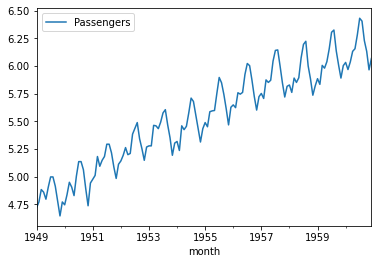

In [ ]:
log_data.plot()

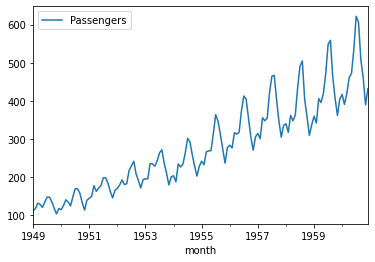

In [ ]:
data.plot()

로그를 씌운 데이터의 경우 분산이 더 줄어들은 것을 확인할 수 있다.

### train, test 분할

In [ ]:
# 시계열에서는 무조건 shuffle=False
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

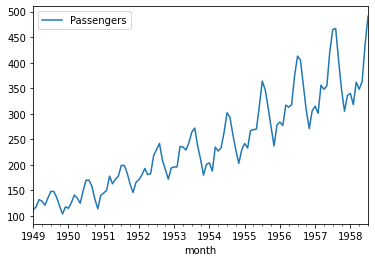

In [ ]:
train_data.plot()

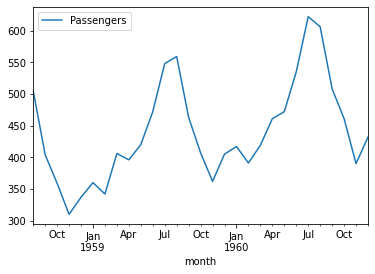

In [ ]:
test_data.plot()

In [ ]:
train_data.values.shape

(115, 1)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


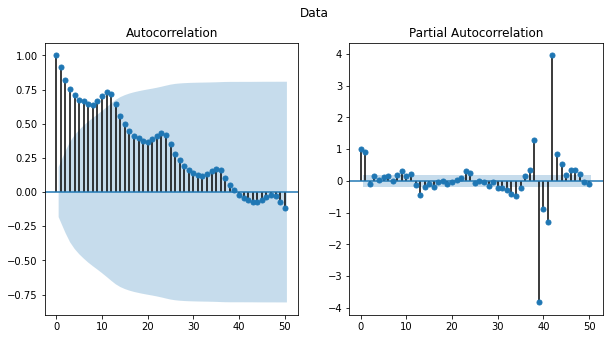

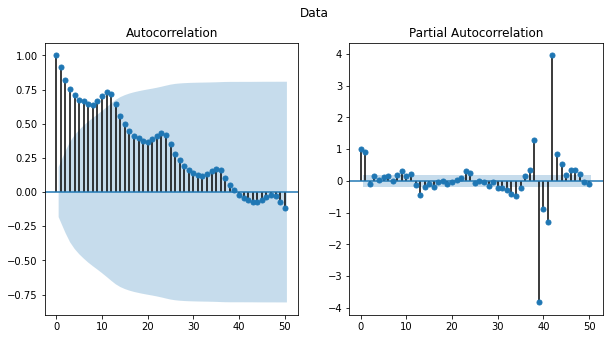

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Data')

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=50, ax=ax[0]) # auto correlation -> 빠르게 0으로 가야 데이터가 정상이다
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=50, ax=ax[1]) # partial auto correlation

ACF를 봤을 때 0으로 빨리 떨어지지 않는 것을 확인했고 정상성이 낮다고 할 수 있기 때문에 정상화 과정이 필요하다

### 분할한 train, test 데이터셋을 정상화 하기
1. 변동폭이 일정하지 않으면 로그를 씌워 분산을 일정하게 유지되도록 변환
2. 추세/계절적 요인이 관찰되면 차분을 수행해 평균이 일정하게 유지되도록 변환
3. 모두 해당하는 경우 로그와 차분 모두 수행

In [ ]:
log_train_data = np.log(train_data.copy()) # train_data에 로그 씌우기
log_test_data = np.log(test_data.copy()) # test_data에 로그 씌우기
diff_train_data = log_train_data['Passengers'].diff() # 차분 수행 (xt - xt-1)
diff_train_data.dropna(inplace=True) # 맨 앞의 값은 차분이 불가하기 때문에 삭제

diff_train_data

month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1958-03-01    0.129593
1958-04-01   -0.039442
1958-05-01    0.042200
1958-06-01    0.180943
1958-07-01    0.121098
Name: Passengers, Length: 114, dtype: float64

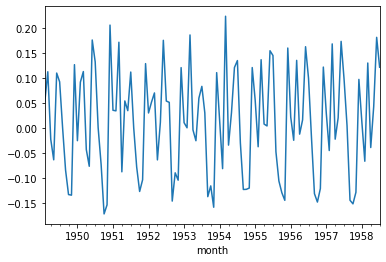

In [ ]:
diff_train_data.plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


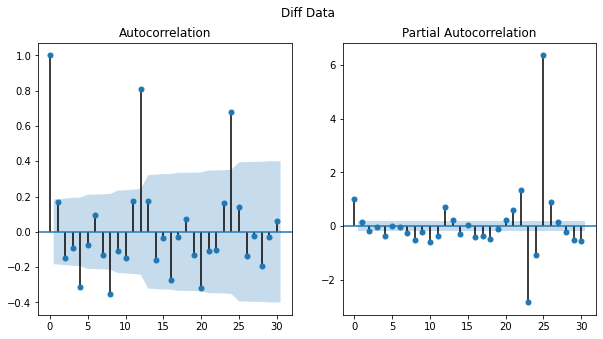

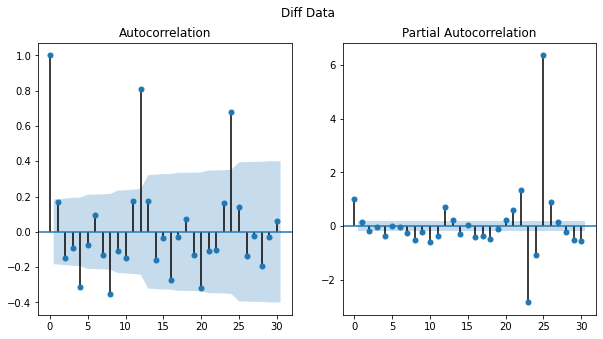

In [ ]:
# 정상화한 상태에서 acf 그려보기
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Diff Data')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0]) # auto correlation -> 빠르게 0으로 가야 데이터가 정상이다
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]) # partial auto correlation

이전과 다르게 acf가 빠르게 0으로 가는 추세를 확인할 수 있음

### 모델링

In [ ]:
                # 모델링할 데이터               # p (AR의 윈도우), d(차분), q(MA의 윈도우)
model = SARIMAX(diff_train_data.values, order=(1,0,1)) # AR(1) order=(1,1,1) => ARIMA(1,1,1), order(0,0,1) => MA(1), SARIMA를 쓴다면, seasonal_order=(2,1,1,12) (p,d,q,계절의 주기(월))
# AR의 1과 MA의 1을 더해서 쓰겠다. 차분은 아까 했으니까 0
history = model.fit() 
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 101.611
Date:                Sat, 16 Jul 2022   AIC                           -197.221
Time:                        12:56:34   BIC                           -189.013
Sample:                             0   HQIC                          -193.890
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5721      0.184     -3.104      0.002      -0.933      -0.211
ma.L1          0.8375      0.109      7.669      0.000       0.623       1.052
sigma2         0.0098      0.002      5.359      0.000       0.006       0.013
===================================================================================
Ljung-Box (Q):                      263.05   Jarque-Bera (JB):                 5.61
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.02   Skew:                             0.13
Prob(H) (two-sided):                  0.95   Kurtosis:                         1.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Log Likelihood : 정확도(높을수록 좋음)     
AIC : Log Likelihood의 역수의 가중(낮으면 낮을수록 좋음)

In [ ]:
pred = history.get_forecast(len(log_test_data)) # 예측을 할 값의 길이

In [ ]:
pred

In [ ]:
pred_df = pd.DataFrame()
pred_df['mean'] = pred.predicted_mean #예측값

### 최적의 ARIMA 모델 찾기

In [ ]:
forecast_value = log_train_data['Passengers'].iloc[-1] + pred_df['mean'].cumsum() # 차분을 복원하는 코드, 다시 누적함수를 더해줌

In [ ]:
pred.conf_int() # 상한, 하한

array([[-0.17600954,  0.212454  ],
       [-0.21138019,  0.19052957],
       [-0.19714263,  0.20907169],
       [-0.20721914,  0.20039428],
       [-0.20208285,  0.20598749],
       [-0.20522685,  0.20299293],
       [-0.20349531,  0.20477338],
       [-0.20450795,  0.20377674],
       [-0.2039358 ,  0.20435414],
       [-0.2042655 ,  0.20402615],
       [-0.20407764,  0.20421457],
       [-0.20418537,  0.20410703],
       [-0.20412382,  0.20416864],
       [-0.20415906,  0.20413342],
       [-0.2041389 ,  0.20415358],
       [-0.20415044,  0.20414204],
       [-0.20414384,  0.20414864],
       [-0.20414762,  0.20414487],
       [-0.20414546,  0.20414703],
       [-0.20414669,  0.20414579],
       [-0.20414598,  0.2041465 ],
       [-0.20414639,  0.20414609],
       [-0.20414616,  0.20414633],
       [-0.20414629,  0.20414619],
       [-0.20414621,  0.20414627],
       [-0.20414626,  0.20414623],
       [-0.20414623,  0.20414625],
       [-0.20414625,  0.20414624],
       [-0.20414624,

차분을 복원하는 과정이 매우 번거롭기 때문에 ARIMA 모델에 넣을 때는 로그를 취한 값만 넣고 차분은 모델에서 설정한다

In [ ]:
                # 모델링할 데이터               # p (AR의 윈도우), d(차분), q(MA의 윈도우)
model = SARIMAX(log_train_data.values, order=(2,1,1)) # AR(1) order=(1,1,1) => ARIMA(1,1,1), order(0,0,1) => MA(1), SARIMA를 쓴다면, seasonal_order=(2,1,1,12) (p,d,q,계절의 주기(월))
# AR의 1과 MA의 1을 더해서 쓰겠다. 차분은 아까 했으니까 0
history = model.fit() 
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 103.850
Date:                Sat, 16 Jul 2022   AIC                           -199.699
Time:                        12:56:34   BIC                           -188.755
Sample:                             0   HQIC                          -195.257
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9456      0.121      7.823      0.000       0.709       1.182
ar.L2         -0.3384      0.132     -2.558      0.011      -0.598      -0.079
ma.L1         -0.8183      0.133     -6.170      0.000      -1.078      -0.558
sigma2         0.0094      0.002      5.552      0.000       0.006       0.013
===================================================================================
Ljung-Box (Q):                      296.61   Jarque-Bera (JB):                 7.70
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.17   Skew:                             0.28
Prob(H) (two-sided):                  0.63   Kurtosis:                         1.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred = history.get_forecast(len(log_test_data)) # 예측을 할 값의 길이

In [ ]:
pred.predicted_mean # 차분이 복원된 값이 나옴

array([6.16258634, 6.08959388, 6.03203206, 6.00230346, 5.99367135,
       5.9955689 , 6.00028414, 6.00410057, 6.00611367, 6.00672576,
       6.00662332, 6.00631933, 6.00606656, 6.00593041, 6.00588721,
       6.00589243, 6.00591199, 6.00592871, 6.00593791, 6.00594095,
       6.0059407 , 6.00593945, 6.00593834, 6.00593772, 6.00593751,
       6.00593752, 6.0059376 , 6.00593767, 6.00593772])

In [ ]:
# 최적의 p, d, q 찾기

p = range(1, 3)
d = range(0, 2)
q = range(1, 3)

pdq = list(itertools.product(p, d, q))

aic = []

for i in pdq:
    model = SARIMAX(log_train_data.values, order=(i))
    model_fit = model.fit()
    aic.append(model_fit.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
aic

[-185.19237594310997,
 -188.33293543805075,
 -197.22146393706288,
 -199.9396757942086,
 -182.13245535158867,
 -182.67656097536687,
 -199.69933238430536,
 -199.30517709004374]

In [ ]:
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((1, 1, 2), -199.9396757942086)]

In [ ]:
opt_model = SARIMAX(log_train_data.values, order=optimal[0][0]) # 최적의 파라미터로 모델링
opt_model_fit = opt_model.fit()

opt_model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 103.970
Date:                Sat, 16 Jul 2022   AIC                           -199.940
Time:                        12:56:36   BIC                           -188.995
Sample:                             0   HQIC                          -195.498
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5048      0.163      3.103      0.002       0.186       0.824
ma.L1         -0.3352      0.174     -1.928      0.054      -0.676       0.006
ma.L2         -0.4229      0.103     -4.119      0.000      -0.624      -0.222
sigma2         0.0094      0.002      4.843      0.000       0.006       0.013
===================================================================================
Ljung-Box (Q):                      273.46   Jarque-Bera (JB):                 7.38
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               1.12   Skew:                             0.08
Prob(H) (two-sided):                  0.73   Kurtosis:                         1.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 평가

In [ ]:
pred = opt_model_fit.get_forecast(len(log_test_data))

In [ ]:
pred

In [ ]:
test_data

,Passengers
month,
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396


In [ ]:
pred.predicted_mean # 로그를 씌운 값

array([6.15518182, 6.08547605, 6.05028558, 6.03251992, 6.02355104,
       6.01902317, 6.01673731, 6.0155833 , 6.01500071, 6.0147066 ,
       6.01455811, 6.01448315, 6.01444531, 6.0144262 , 6.01441656,
       6.01441169, 6.01440923, 6.01440799, 6.01440736, 6.01440705,
       6.01440689, 6.01440681, 6.01440677, 6.01440675, 6.01440674,
       6.01440673, 6.01440673, 6.01440673, 6.01440673])

In [ ]:
np.exp(pred.predicted_mean) # 실제 예측 값

array([471.15249828, 439.4289541 , 424.23416608, 416.7639175 ,
       413.04272743, 411.17675007, 410.23792885, 409.76478603,
       409.52613049, 409.4056997 , 409.34491451, 409.31423096,
       409.29874145, 409.2909219 , 409.28697432, 409.28498142,
       409.28397532, 409.2834674 , 409.28321098, 409.28308153,
       409.28301618, 409.28298319, 409.28296653, 409.28295812,
       409.28295388, 409.28295173, 409.28295065, 409.28295011,
       409.28294983])

In [ ]:
pred.conf_int()

array([[5.9650535 , 6.34531013],
       [5.79289294, 6.37805917],
       [5.71763479, 6.38293638],
       [5.67683705, 6.38820278],
       [5.65137318, 6.3957289 ],
       [5.63329948, 6.40474686],
       [5.61896525, 6.41450936],
       [5.606611  , 6.42455561],
       [5.59536583, 6.43463559],
       [5.58479024, 6.44462295],
       [5.57465786, 6.45445836],
       [5.56484891, 6.46411739],
       [5.55529736, 6.47359326],
       [5.54596461, 6.4828878 ],
       [5.53682634, 6.49200678],
       [5.52786577, 6.5009576 ],
       [5.51907036, 6.50974811],
       [5.51042996, 6.51838602],
       [5.501936  , 6.52687873],
       [5.49358094, 6.53523316],
       [5.48535801, 6.54345577],
       [5.47726104, 6.55155257],
       [5.46928438, 6.55952915],
       [5.4614228 , 6.56739069],
       [5.45367143, 6.57514204],
       [5.44602578, 6.58278768],
       [5.43848162, 6.59033184],
       [5.43103501, 6.59777844],
       [5.42368226, 6.60513119]])

In [ ]:
np.exp(pred.conf_int()[:,0])

array([389.57387088, 327.96042302, 304.1846096 , 292.02430926,
       284.68211854, 279.58307723, 275.60405434, 272.22011826,
       269.1761056 , 266.34440787, 263.6593331 , 261.08575449,
       258.60385086, 256.20159408, 253.87101861, 251.60635298,
       249.40307307, 247.25741441, 245.16611428, 243.12626997,
       241.13525665, 239.19067618, 237.29032283, 235.43215839,
       233.61429289, 231.83496908, 230.09254925, 228.38550402,
       226.71240252])

In [ ]:
# upper bound
np.exp(pred.conf_int()[:,1])

array([569.8140795 , 588.78386581, 591.66250361, 594.7866579 ,
       599.27998135, 604.70870223, 610.64108318, 616.80665245,
       623.0554944 , 629.30935283, 635.5294048 , 641.69774406,
       647.80728978, 653.85642644, 659.84620167, 665.77888051,
       671.65721093, 677.48405882, 683.26223339, 688.99440956,
       694.68309886, 700.33064416, 705.93922538, 711.51086987,
       717.04746426, 722.55076637, 728.02241638, 733.46394714,
       738.87679351])

In [ ]:
predicted_values = np.exp(pred.predicted_mean)
pred_lb = np.exp(pred.conf_int()[:,0]) # lower bound
pred_ub = np.exp(pred.conf_int()[:,1]) # upper bound

In [ ]:
predicted_values

array([471.15249828, 439.4289541 , 424.23416608, 416.7639175 ,
       413.04272743, 411.17675007, 410.23792885, 409.76478603,
       409.52613049, 409.4056997 , 409.34491451, 409.31423096,
       409.29874145, 409.2909219 , 409.28697432, 409.28498142,
       409.28397532, 409.2834674 , 409.28321098, 409.28308153,
       409.28301618, 409.28298319, 409.28296653, 409.28295812,
       409.28295388, 409.28295173, 409.28295065, 409.28295011,
       409.28294983])

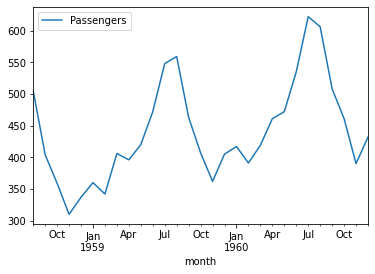

In [ ]:
test_data.plot() # 실제 데이터

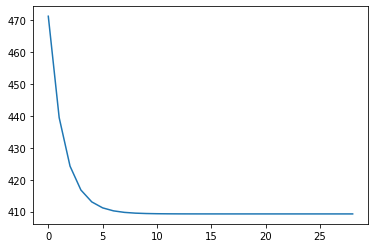

In [ ]:
plt.plot(predicted_values)

Text(0.5, 0.98, 'ARIMA (1, 1, 2) Prediction Result (r2 score: -0.14269224677832937)')

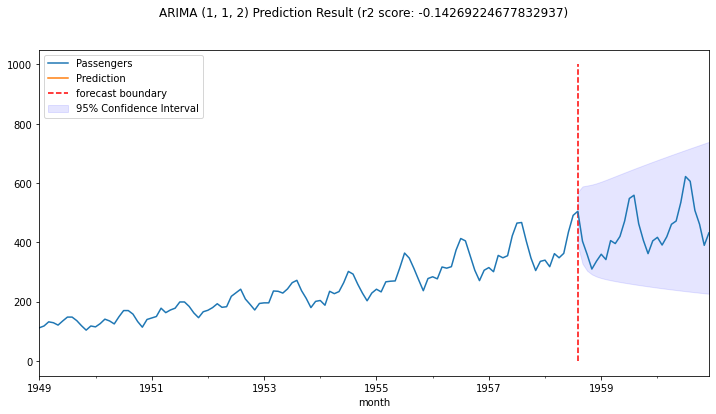

In [ ]:
fig = plt.figure(figsize= (12, 6))
ax = fig.add_subplot(111)

pred_index = list(test_data.index)
r2 = r2_score(test_data, predicted_values)

data.plot(ax=ax)
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='forecast boundary')
ax.fill_between(pred_index, pred_lb, pred_ub, color='b', alpha=0.1, label='95% Confidence Interval')
ax.plot(pred_index, predicted_values, label='Prediction')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Result (r2 score: {r2})')
# 예측 범위 시각화

In [ ]:
opt_model = SARIMAX(log_train_data.values, order=(1,1,2), seasonal_order=(1,1,2,12)) # 계절성 반영
opt_model_fit = opt_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
pred = opt_model_fit.get_forecast(len(test_data))
predicted_values = np.exp(pred.predicted_mean)
pred_lb = np.exp(pred.conf_int()[:,0]) # lower bound
pred_ub = np.exp(pred.conf_int()[:,1]) # upper bound

Text(0.5, 0.98, 'ARIMA (1, 1, 2) Prediction Result (r2 score: 0.9588096623309489)')

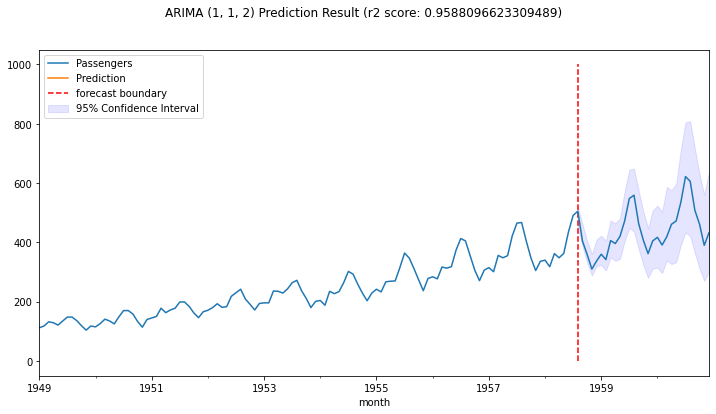

In [ ]:
fig = plt.figure(figsize= (12, 6))
ax = fig.add_subplot(111)

pred_index = list(test_data.index)
r2 = r2_score(test_data, predicted_values)

data.plot(ax=ax)
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='forecast boundary')
ax.fill_between(pred_index, pred_lb, pred_ub, color='b', alpha=0.1, label='95% Confidence Interval')
ax.plot(pred_index, predicted_values, label='Prediction')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Result (r2 score: {r2})')
# 예측 범위 시각화

계절성이 잘 반영된 모습 확인

### ADF(Augumented Dickey-Fuller) TEST
귀무가설(H0) : non-stationary    
대체가설(H1) : stationary     
통계적으로 정상성 확인 p-hacking 문제가 있기 때문에 맹신하지 말고 참고용으로만 볼 것

In [ ]:
from statsmodels.tsa.stattools import adfuller

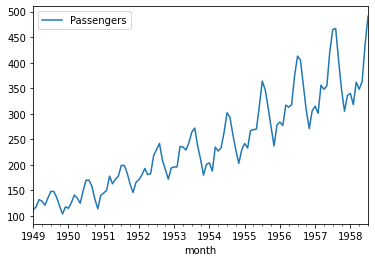

In [ ]:
train_data.plot()

In [ ]:
result = adfuller(train_data['Passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.356889
p-value: 0.917052
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


p-value를 보고 정상이 아니다라는 결론

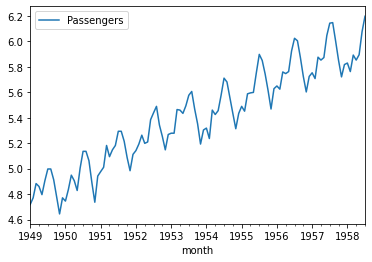

In [ ]:
np.log(train_data).plot()

In [ ]:
result = adfuller(np.log(train_data['Passengers']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.574027
p-value: 0.496626
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


p-value가 여전히 높기 때문에 정상이 아니다

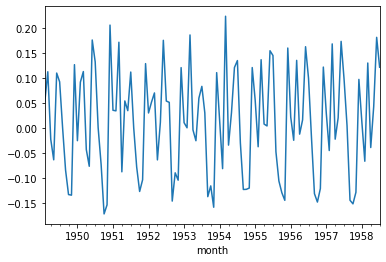

In [ ]:
diff_train_data.plot()

In [ ]:
result = adfuller(diff_train_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.635851
p-value: 0.085812
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


p-value와 실제 diff_train_data를 이용해 예측한 모델과의 괴리가 있다.    
0.05를 넘긴 하지만 실제 예측 결과는 어느정도 잘 예측함     
p-hacking의 문제점 : p-value가 0.05 이상이면 기각